We obtained historical data from Yahoo Finance for three major indicies to track overall movments in the stock market. The data was obtained over the past year, at a random point in time each day. Some days there are more data points than others, so we will use the latest collected data point for each day.

The stocks are the SPDR S&P 500 ETF (SPY), Invesco QQQ Trust (QQQ), and the iShares Russel 2000 (IWM). The options on these stocks are traded heavily by investors, therefore there is a huge interest in pricing these particular options. 

We decided to narrow our to the expiration date of 3/17/23. For this expiration, we have over 150+ data points for each contract. 


In our main program, we first requre the inputs from the user. We need the current stock price, the strike price, the risk-free rate, the volatility, the days until the option contract expires, and the number of simulated stock price paths to generate. 

After the inputs are provided, the function indpendently generates stock price paths for each of the methods we have proveded to estimate the present value of an option contract. 

In [1]:
from Models import OptionSim
import numpy as np
import pandas as pd 
file = 'data/setup/data_final_set.csv'
df = pd.read_csv(file)
df['gatherdate'] = pd.to_datetime(df['gatherdate'])
df['gatherdate'] = df['gatherdate'].dt.date
df = df.groupby(['contractsymbol', 'gatherdate']).last().reset_index()
df['Date'] = [str(x)[:10] for x in df['gatherdate']]

rf_file = 'data/setup/ten_year.csv'
rf = pd.read_csv(rf_file)

# merge risk free rate with option data
df = pd.merge(df, rf, how='left', left_on='Date', right_on='Date')
df['rf'] = df['rf'].bfill()
df.drop(columns = ['Date', 'expiry', 'timevalue'], inplace=True)
df['mid'] = (df['bid']+df['ask'])/2
# drop all days_to_expiry <= 0 
df = df[df['days_to_expiry']>0]

# # seperate contracts into df 
lodf = []
for contract in df['contractsymbol'].unique():
    t0= df[df['contractsymbol']==contract]
    t0 = t0.groupby('gatherdate').last().reset_index()
    t0.sort_values(by='gatherdate', inplace=True)
    lodf.append(t0)



After seperating contracts into their own dataframes, we can then begin to run simulations on each contract. 



We will run 100 simulations for each contract, on each day that we have observations, then we compare the results. 

**Payoff:** For a Put Option Stock - Strike, for a Call Option Strike - Stock; This is the value of the option contract. 

**Continuation Value:** The value of the option contract at the next time step, ie. You choose to continue to hold the option.

**In the money:** For a Put Option, the stock has fallen below the chosen strike price. For a Call Option, the stock has risen above the chosen strike price.

**State Variable**

The LMSC Methods attempts to approximate the conditional expectation of the payoff now given the continuation value. 

On the day of expiration, it is optimal to exercise the contract if you are in the money. 
Before the expiration, we need to compare the current value with the expected value if we continue to hold the contract.
Therefore with American Options, we are interested in identifying the conditional expected value of continuation given the current value. 

The LSMC method uses cross-sectional information from the simulated paths of the geometric brownian motion to identify the conditional expectation function by the use of least squares regression. Particularly we regress the payoffs from continuation at time $t+1, t+2, ..$ on basis functions of the state variable at time $t$. The fitted value from the regression is an unbiased estimate of the conditional expectation function and allows us to accurately estimate the optimal stopping rule for that option for each simulated path. 

The algorithim is recursive and works backwards from the expiration date to get the current value given the continuation value of the option. 

For example, say we have put option contract that we can exercise at any time $t = \{1, 2, 3\}$

The payoff at time $t=3$ is $max(0, K - S_{t=3})$

The payoff at time $t=2$ is $max(0, K - S_{t=2}) | max(0, K - S_{t=3})$

Let $X$ denote the stock prices at time $t=2$ for the paths that we have simulated and decided to exercise on day $t=3$.

Let $Y$ denote the corresponding dicounted payoff recieved at time $t=3$ if the put option is not exercised at time $t=2$.

We only use in the money paths since it allows us to better estimate the conditional expectation function in the region where exercise is relevant. 

To get the immediate value of the option at time $t=2$, we regress $Y$ on a constant $X$ and $X^2$ using least squares regression, to obtain the conditional expectation function $E(Y|X) = \beta_0 + \beta_1 X + \beta_2 X^2$. Where $\beta_0, \beta_1, \beta_2$ are the coefficients of the regression model. We compare the fitted value from the function to the payoff at time $t = 3$. 

If the immediate payoff is greater than the continuation value, we exercise the option. If the continuation value is greater than the immediate payoff, we continue to hold the option. If stock price is situated so that the option is out of the money, the option is worthless and thus the payoff is zero. If we choose to exercise before the expiration date, then all future payoffs for that path are also zero. So the realized payoff will be a matrix of zeros and discounted payoffs. 

Proceeding backwards we examine if the option should be exercised at time $t=1$. Let $Y$ denote the dicounted value of future realized payoff along each path. We use the actual realized payoff along each path at time $t=2$ to regress on the fitted value of the conditional expectation function at time $t=1$, not the the conditional expected value of $Y$ at time $t=2$. As stated in the paper, this leads to an upward bias in the value of the option. 

Finally after obtaining the cashflows from the regression for each path, we discount the cashflows to the time $t = 0$ and taking the average of all paths, to obtain the present value of the option contract. This is the estimated value of the option contract, and can be thought of as the sample mean of the simulation study. 

So in total there are $K = 3$ times where the option can be exercised. If we increase the number of time steps $K$ to be sufficiently large we can estiamte the value of the option using many exercise points, which resemeble the continuous exercise feature of the american option.  $0 < t_1 ≤ t_2 ≤ t_3 ≤ ... ≤ t_K ≤ T$.

Since we use the sample mean of the cashflows as the estimator of the expected value of the option. We run $r$ independent simulations to get the sample mean $Z_i$ of the cashflows. The sample mean is an unbiased estimator of the conditional expectation of the option price. Thus, we can estimate the variance of $Z_i$ by taking the sample variance of all $Z_i$'s 

$$\hat{\sigma}^2 = \frac{1}{r}\sum_{i=1}^r (Z_i - \bar{Z})^2$$

where $\bar{Z}$ is the sample mean of all $Z_i$'s. 

The nice part about this method is that it is easy to implement, and it is very flexible. We can use various kinds of basis functions to approximate the conditional expectation function. Another nice feature is that it is easy to extend to other types of options, such as Asian options, barrier options, and lookback options. 

If we use the method of independent replications we obtain the following results:




In [2]:
from IPython.display import display
tmp= lodf[1]
#display(tmp.iloc[10])
sim_inputs = tmp.iloc[10][['stk_price','strike', 'rf','days_to_expiry', 'impliedvolatility', 'type', 'mid']]
S0, K, r, days, sigma, option_type, Observed = sim_inputs


# create a simulation object
sim = OptionSim(S0, K, r, days, sigma, option_type, 1000, Observed)
sim.run_ir()

,LSMC Normal μ,LSMC Poly μ,LSMC CV μ,MC μ,BS,LSMC Poly SE,LSMC Normal SE,LSMC CV SE,MC SE,LSMC Normal CI,LSMC Poly CI,LSMC CV CI,MC CI,Observed
0,11.784683,23.6767,23.794449,22.737331,22.872547,0.07907,0.006716,0.098756,0.127293,"[11.772371666788164, 11.796993607647792]","[23.531755227845338, 23.821645223261328]","[23.613417622495355, 23.975480195199417]","[22.503989115089656, 22.970672602911915]",23.08


In [3]:
from tqdm import tqdm
# suppress runtime warnings
import warnings
warnings.filterwarnings("ignore")
N = 1000
alldf = []
for j in tqdm(range(len(lodf))):
    tmp = lodf[j]
    out = []
    for i in tqdm(range(0, len(tmp) , 1)):
        D = tmp.iloc[i].copy()
        try:
            sim_input = D[['gatherdate','stk_price','strike', 'rf','days_to_expiry', 'impliedvolatility', 'type', 'mid']]
            S0, K, r, days, sigma, option_type, Observed = sim_input[1:]
            sim = OptionSim(S0, K, r, days, sigma, option_type, N, Observed)
            o = sim.run_ir(replications= 9)
            o.insert(0, 'gatherdate', sim_input[0])
            o.insert(1, 'contractsymbol', D['contractsymbol'] )
            out.append(o)
        except:
            continue

    t = pd.concat(out)
    alldf.append(t)

sim_df = pd.concat(alldf)

100%|██████████| 6/6 [34:03<00:00, 340.55s/it]


In [7]:
lodf[0][['gatherdate','stk_price','strike', 'rf','days_to_expiry', 'impliedvolatility', 'type', 'mid']].iloc[0].values

array([datetime.date(2022, 4, 11), 197.0500030517578, 185.0,
       0.0277999997138977, 340, 0.2989572058105468, 'Call', 27.79],
      dtype=object)

In [4]:
c = ['gatherdate', 'contractsymbol', 'LSMC Normal μ', 'LSMC CV μ','LSMC Poly μ','MC μ','BS', 'Observed']
sim_df

,gatherdate,contractsymbol,LSMC Normal μ,LSMC Poly μ,LSMC CV μ,MC μ,BS,LSMC Poly SE,LSMC Normal SE,LSMC CV SE,MC SE,LSMC Normal CI,LSMC Poly CI,LSMC CV CI,MC CI,Observed
0,2022-04-11,IWM230317C00185000,13.630558,36.695770,34.569697,35.929689,36.358066,0.180256,0.545549,0.213725,0.184067,"[12.616083889673844, 14.645033016636352]","[36.36057578019063, 37.03096423761319]","[34.17226523273483, 34.96712798760798]","[35.58740732950157, 36.27197120324931]",27.790
0,2022-04-20,IWM230317C00185000,17.546616,40.596961,36.666999,39.915737,39.296922,0.208505,0.008774,0.524385,0.224705,"[17.530299792287725, 17.56293277492418]","[40.20923702228049, 40.984685549816746]","[35.69188047482822, 37.64211751249439]","[39.49788731799074, 40.333587549309335]",30.840
0,2022-04-25,IWM230317C00185000,7.348631,31.508968,31.572554,30.893828,31.436742,0.221469,0.013467,0.223912,0.147512,"[7.323587605823589, 7.373674377833573]","[31.097136677082744, 31.920799742335284]","[31.15617925350535, 31.988927957849384]","[30.619521402557538, 31.168134008682316]",23.860
0,2022-05-03,IWM230317C00185000,6.201522,28.270946,28.399422,28.540096,28.650074,0.147384,0.019773,0.309573,0.198458,"[6.164752282668557, 6.238291537901269]","[27.99687828936746, 28.54501292058032]","[27.823755567397075, 28.975088531360964]","[28.171054066263594, 28.909138762622618]",21.130
0,2022-05-06,IWM230317C00185000,12.165088,24.557843,24.334619,24.402509,24.298538,0.113394,0.081524,0.075672,0.129029,"[12.013491136561054, 12.316685516403417]","[24.346982404047296, 24.768703854234978]","[24.193903315034877, 24.475334735466273]","[24.162573566562692, 24.642443796644223]",16.965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,2023-03-10,SPY230317P00398000,12.529625,14.378725,14.189807,14.000281,14.057090,0.026283,0.016961,0.052904,0.046724,"[12.498084345188635, 12.56116554399586]","[14.32985053836923, 14.427599050974093]","[14.091430408479702, 14.28818371565698]","[13.91339591866632, 14.087166868326515]",13.845
0,2023-03-13,SPY230317P00398000,12.210065,13.374027,13.727578,13.130092,13.383779,0.034034,0.082792,0.030971,0.042786,"[12.056108309926236, 12.364020910149803]","[13.310738862405023, 13.437315741887042]","[13.66998606240855, 13.78517012566507]","[13.050530030264712, 13.209654908142197]",12.970
0,2023-03-14,SPY230317P00398000,9.014522,10.138168,10.280432,10.249409,10.171325,0.029589,0.021116,0.041623,0.021677,"[8.975255773100422, 9.053788998052987]","[10.08314629798343, 10.19319020013468]","[10.20303249167106, 10.357830708924475]","[10.209098974935756, 10.289719678259292]",10.020
0,2023-03-15,SPY230317P00398000,9.906446,10.518559,10.586162,10.577087,10.555837,0.035315,0.032300,0.023407,0.038416,"[9.84638388806907, 9.966508852757613]","[10.452888974979741, 10.584228474491725]","[10.542635652232606, 10.629689103465408]","[10.50565177939792, 10.648523191362132]",10.530


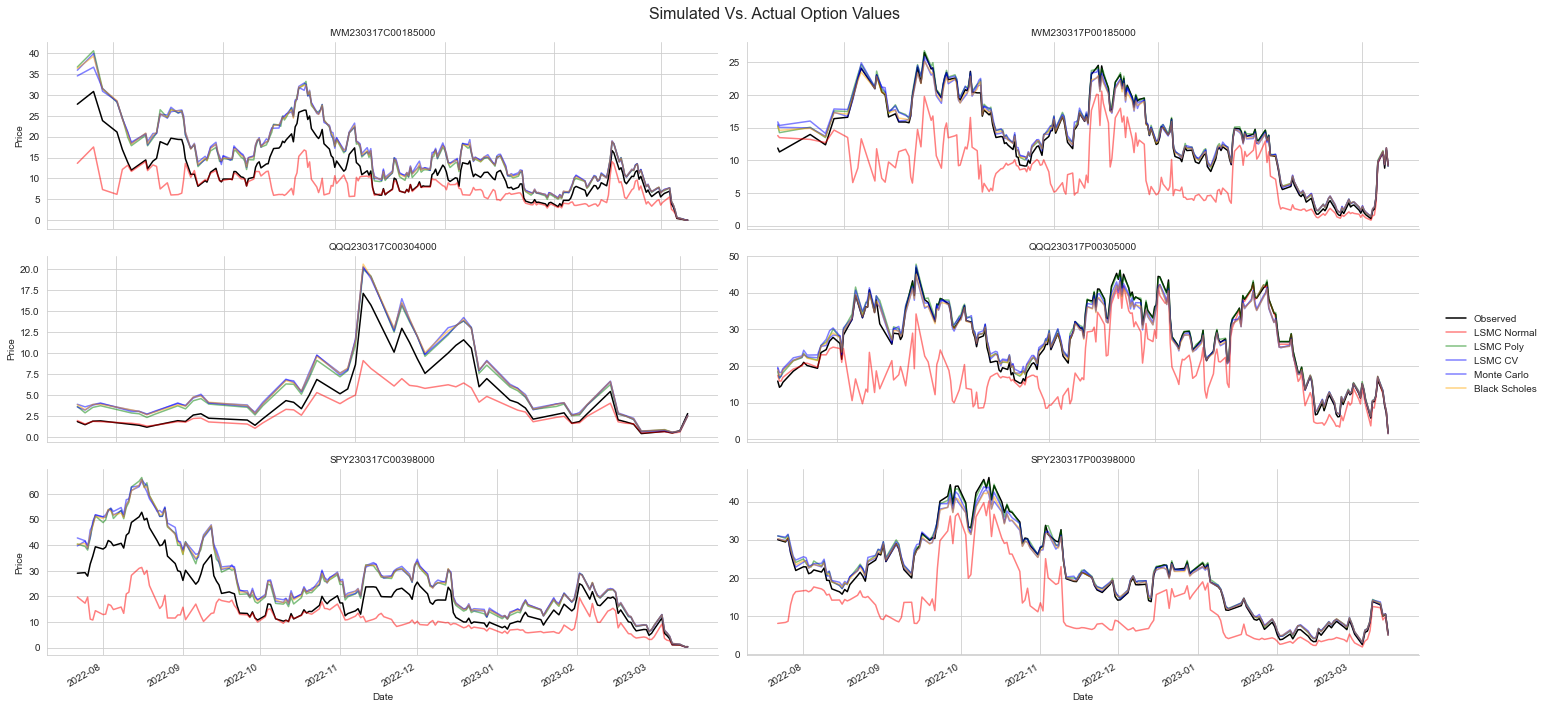

In [5]:
# tmp_new = tmp.merge(t, on=['gatherdate', 'contractsymbol'], how='left').copy()
# cols = ['gatherdate', 'stock', 'type', 'strike', 'stk_price','impliedvolatility', 'days_to_expiry', 'rf', 'mid', 'ask', 'bid', 'LSMC Normal', 'LSMC Poly', 'MC', 'BS']
# tmp_new[cols]
# pdf = tmp_new.copy().set_index('gatherdate').sort_index(ascending = False)
import seaborn as sns 
import matplotlib.pyplot as plt
import datetime as dt 
sns.set_style('whitegrid')
# # create a facet grid for each contract 
g= sns.FacetGrid(sim_df, col='contractsymbol',col_wrap=2,sharex=False,sharey=False)
g.map_dataframe(sns.lineplot, x='gatherdate',y='Observed',label = 'Observed', color = 'black')
g.map_dataframe(sns.lineplot, x='gatherdate',y='LSMC Normal μ', color = 'red', label = 'LSMC Normal', alpha = 0.5)
g.map_dataframe(sns.lineplot, x='gatherdate',y='LSMC Poly μ', color = 'green', label = 'LSMC Poly', alpha = 0.5)
g.map_dataframe(sns.lineplot, x='gatherdate',y='LSMC CV μ', color = 'blue', label = 'LSMC CV', alpha = 0.5)
g.map_dataframe(sns.lineplot, x='gatherdate',y='MC μ', color = 'blue', label = 'Monte Carlo', alpha = 0.5)
g.map_dataframe(sns.lineplot, x='gatherdate',y='BS', color = 'orange', label = 'Black Scholes', alpha = 0.5)
g.set_axis_labels('Date', 'Price')
g.set_titles('{col_name}')
g.fig.set_figwidth(20)
g.fig.set_figheight(10)
g.fig.autofmt_xdate()
g.fig.suptitle('Simulated Vs. Actual Option Values', fontsize=16)
g.add_legend()
g.tight_layout()
plt.show()
g.savefig('simulated_vs_actual.jpeg')

The simulation methods seemed to perform better for the Put contracts than the calls with the data we have provided. The Black scholes model seemed to give a close approximate to the observed price of the option; however as seen below, the LSMC method seems to be more accurate.

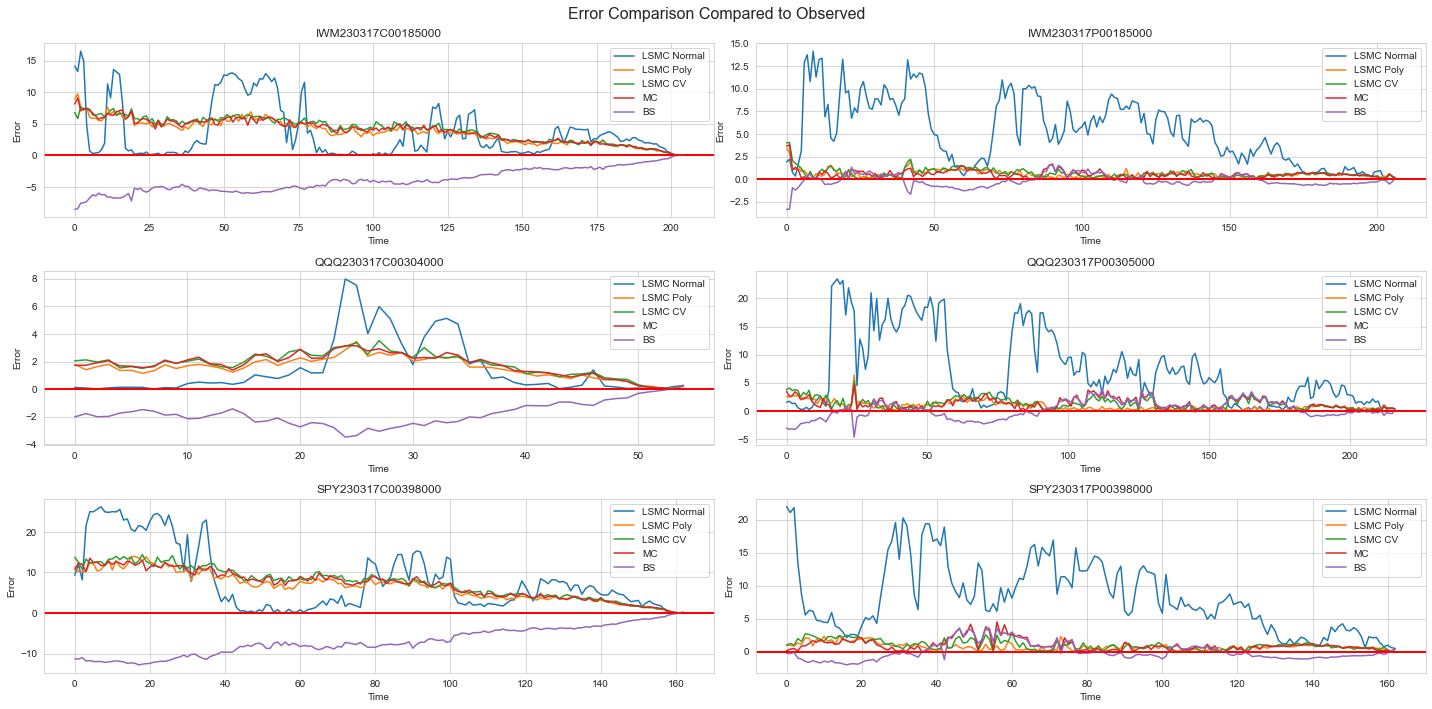

In [6]:
fig, ax = plt.subplots(3,2,  figsize=(20, 10))
ax = ax.flatten()
for i, contract in enumerate(df['contractsymbol'].unique()):
    for meth in ['LSMC Normal','LSMC Poly', 'LSMC CV','MC', 'BS']:
        t = sim_df[sim_df['contractsymbol']==contract].copy()
        t = t.groupby('gatherdate').last().reset_index()
        t.sort_values(by='gatherdate', inplace=True)
        if meth == 'BS':
            t['BS error'] = t['Observed'] - t['BS']
        else:
            t[f'{meth} error'] = np.abs(t['Observed'] - t[f'{meth} μ'])
        t[f'{meth} error'].plot(ax=ax[i], title=contract, label=meth)
        ax[i].set_xlabel('Time')
        ax[i].set_ylabel('Error')
        ax[i].axhline(0, color='r')
        ax[i].legend()
fig.suptitle('Error Comparison Compared to Observed', fontsize=16)
fig.tight_layout()
fig.savefig('error_comparison.jpeg')
plt.show()

The errors for the Put contracts (Right) are much closer to 0 than compared to the Calls (Left). We can note that the LSMC with a Normal Basis function performed the worst for all contracts, having a very high variablity in its fair value approximation. 

In [7]:
out_df = df.copy()
tmp = out_df.merge(sim_df, on=['gatherdate', 'contractsymbol'], how='left').copy()
tmp = tmp.drop(columns = ['gatherdate', 'lastprice', 'ask', 'bid', 'inthemoney', 'mid'])
tmp = tmp.rename(columns = {'stock':'Ticker', 'strike':'K', 'stk_price': 'S', 'impliedvolatility':'𝛔', 'days_to_expiry':'T', 'rf':'r'})

tmp['LSMC Normal error'] = np.abs(tmp['Observed'] - tmp['LSMC Normal μ'])
tmp['LSMC Poly error'] = np.abs(tmp['Observed'] - tmp['LSMC Poly μ'])
tmp['LSMC CV error'] = np.abs(tmp['Observed'] - tmp['LSMC CV μ'])
tmp['MC error'] = np.abs(tmp['Observed'] - tmp['MC μ'])
tmp['BS error'] = np.abs(tmp['Observed'] - tmp['BS'])

tmp['LSMC Normal Early Exercise'] = np.abs(tmp['LSMC Normal μ'] - tmp['BS'])
tmp['LSMC Poly Early Exercise'] = np.abs(tmp['LSMC Poly μ'] - tmp['BS'])
tmp['LSMC CV Early Exercise'] = np.abs(tmp['LSMC CV μ'] - tmp['BS'])
tmp['MC Early Exercise'] = np.abs(tmp['MC μ'] - tmp['BS'])

file = '../data/output/full_results.csv'
tmp.to_csv(file, index=False)

Text(0.5, 0.98, 'Early Exercise Comparison Compared to Black Scholes')

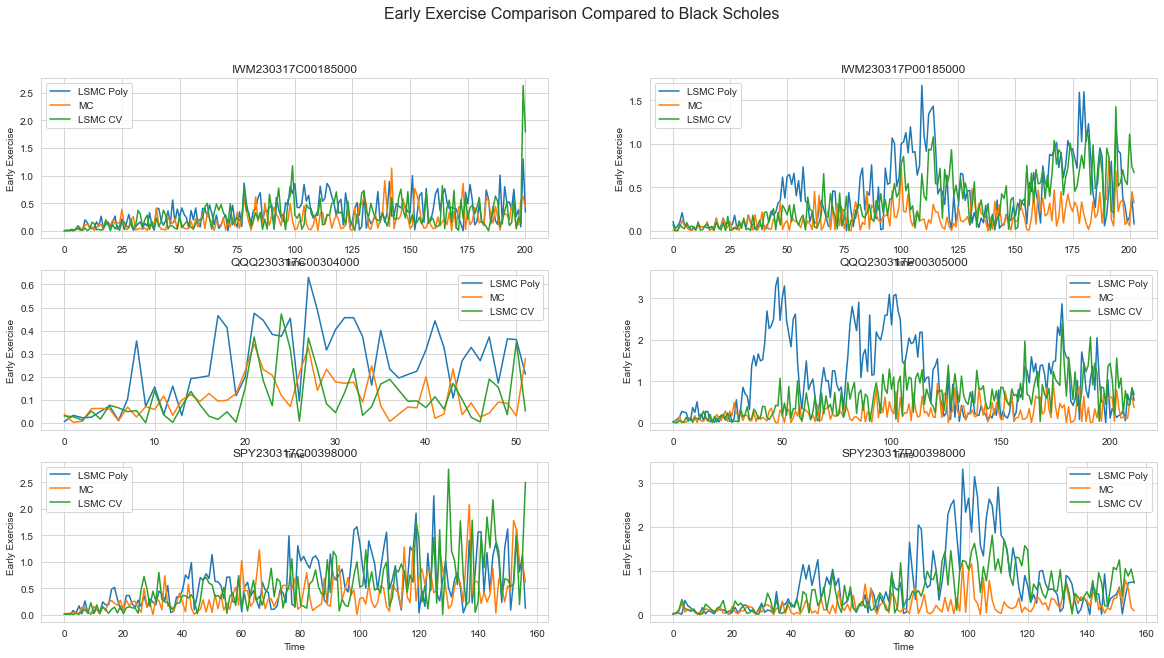

In [43]:
# plot the early exercise over time
fig, ax = plt.subplots(3,2,  figsize=(20, 10))
ax = ax.flatten()
for i, contract in enumerate(df['contractsymbol'].unique()):
    #for meth in ['LSMC Normal','LSMC Poly', 'MC']:
    for meth in ['LSMC Poly', 'MC', 'LSMC CV', ]:
        t = tmp[tmp['contractsymbol']==contract].copy()
        t = t.groupby('T').last().reset_index()
        t.sort_values(by='T', inplace=True)
        t[f'{meth} Early Exercise'].plot(ax=ax[i], title=contract, label=meth)
        ax[i].set_xlabel('Time')
        ax[i].set_ylabel('Early Exercise')
        ax[i].legend()
fig.suptitle('Early Exercise Comparison Compared to Black Scholes', fontsize=16)

# time horizion comparisons
We note that the LSMC method is able to estimate the value of the option contract very well especially with a shorter time until expiration. Simulations methods proved to be more accurate with less days until the expiration, with the LSMC Normal Basis Function perofming the worst accros all time horizions. 

# standard error comparisons

We can see that the Simulation methods give a noticieably lower standard error for short term contracts than longer term, with simulated results differing within 1 cent of the average simulated fair value. 

Since we can get the european component of an option price from the Black-Scholes Model, we already know the price of the option at expiraton. The early exercise component of an american option is the difference between the european price and the simulated american option price we have obtained from the methods above. The early exercise value can be thought of the the excess value of the option compared to if you held it to expiration. So if we notice that the early exercise is high, we might want to exercise the option early, to get the most value out of the opiton, and vice versa if the early exercise value is negative. Thus the table above shows the difference between the simulated methods and the black scholes method, and it clearly shows that the LSMC Normal Basis Function is the worst at estimating the early exercise value. The Polynomial Basis Function performed the best, and the finite difference simulation had similar results to the polynomial basis function. The difference between the black scholes method and the simulated methods is well within the bid-ask spread for these option contracts, which suggest that the simulated methods are able to approximate the early exercise value of the option contracts very well.

In [103]:
c0 = ['contractsymbol', 'Ticker', 'type', 'K', 'S', '𝛔', 'T', 'r']
c0 = [ 'K', 'S', '𝛔']
c1 = ['Observed','BS', 'LSMC Normal μ','LSMC Poly μ', 'LSMC CV μ','MC μ']
c2 = ['LSMC Normal SE', 'LSMC Poly SE','LSMC CV SE','MC SE']
c4 = ['LSMC Normal Early Exercise', 'LSMC Poly Early Exercise','LSMC CV Early Exercise','MC Early Exercise']
e0 = ['LSMC Normal error','LSMC Poly error', 'LSMC CV error','MC error', 'BS error']


# get the avg se for each method, for each contract 
output = tmp.copy()
short = output.query('T< 10').copy()
mid = output.query('T>= 10 & T< 90').copy()
long = output.query('T>= 90').copy()

a = short.groupby('contractsymbol')[c2].mean().reset_index().round(2)
b = mid.groupby('contractsymbol')[c2].mean().reset_index().round(2)
c = long.groupby('contractsymbol')[c2].mean().reset_index().round(2)

#display(a, b, c)
#print(output.set_index(['Ticker','contractsymbol','type','T'])[c0 + c4].query('T>=2 & T<=2').round(2).to_csv())
print(output.set_index(['Ticker','contractsymbol','type','T'])[c0 + c4].query('T<=2').round(2).to_csv())
output.set_index(['Ticker','contractsymbol','type','T'])[c0 + c4].query('T<=2').round(2)

Ticker,contractsymbol,type,T,K,S,𝛔,LSMC Normal Early Exercise,LSMC Poly Early Exercise,LSMC CV Early Exercise,MC Early Exercise
iwm,IWM230317C00185000,Call,2,185.0,173.06,0.39,0.0,0.01,0.0,0.01
iwm,IWM230317C00185000,Call,1,185.0,175.96,0.34,0.0,0.0,0.0,0.0
iwm,IWM230317P00185000,Put,2,185.0,173.06,0.0,0.03,0.03,0.0,0.0
iwm,IWM230317P00185000,Put,1,185.0,175.96,0.53,0.0,0.11,0.07,0.01
qqq,QQQ230317C00304000,Call,2,304.0,297.37,0.28,0.15,0.03,0.03,0.0
qqq,QQQ230317C00304000,Call,1,304.0,305.34,0.23,0.01,0.01,0.03,0.04
qqq,QQQ230317P00305000,Put,2,305.0,297.37,0.0,0.04,0.04,0.0,0.0
qqq,QQQ230317P00305000,Put,1,305.0,305.34,0.23,0.01,0.02,0.01,0.03
spy,SPY230317C00398000,Call,2,398.0,388.65,0.21,0.04,0.01,0.01,0.02
spy,SPY230317C00398000,Call,1,398.0,394.67,0.13,0.01,0.01,0.01,0.01
spy,SPY230317P00398000,Put,2,398.0,388.65,0.32,0.65,0.04,0.03,0.02
spy,SPY230317P00398000,Put,1,398.0,394.67,0.32,0.04,0.0,0.02,0.03



K       S     𝛔   
Ticker contractsymbol     type T                        
iwm    IWM230317C00185000 Call 2  185.0  173.06  0.39  \
                               1  185.0  175.96  0.34   
       IWM230317P00185000 Put  2  185.0  173.06  0.00   
                               1  185.0  175.96  0.53   
qqq    QQQ230317C00304000 Call 2  304.0  297.37  0.28   
                               1  304.0  305.34  0.23   
       QQQ230317P00305000 Put  2  305.0  297.37  0.00   
                               1  305.0  305.34  0.23   
spy    SPY230317C00398000 Call 2  398.0  388.65  0.21   
                               1  398.0  394.67  0.13   
       SPY230317P00398000 Put  2  398.0  388.65  0.32   
                               1  398.0  394.67  0.32   

                                  LSMC Normal Early Exercise   
Ticker contractsymbol     type T                               
iwm    IWM230317C00185000 Call 2                        0.00  \
                               1                        0.00   
       IWM230317P00185000 Put  2                        0.03   
                               1                        0.00   
qqq    QQQ230317C00304000 Call 2                        0.15   
                               1                        0.01   
       QQQ230317P00305000 Put  2                        0.04   
                               1                        0.01   
spy    SPY230317C00398000 Call 2                        0.04   
                               1                        0.01   
       SPY230317P00398000 Put  2                        0.65   
                               1                        0.04   

                                  LSMC Poly Early Exercise   
Ticker contractsymbol     type T                             
iwm    IWM230317C00185000 Call 2                      0.01  \
                               1                      0.00   
       IWM230317P00185000 Put  2                      0.03   
                               1                      0.11   
qqq    QQQ230317C00304000 Call 2                      0.03   
                               1                      0.01   
       QQQ230317P00305000 Put  2                      0.04   
                               1                      0.02   
spy    SPY230317C00398000 Call 2                      0.01   
                               1                      0.01   
       SPY230317P00398000 Put  2                      0.04   
                               1                      0.00   

                                  LSMC CV Early Exercise  MC Early Exercise  
Ticker contractsymbol     type T                                             
iwm    IWM230317C00185000 Call 2                    0.00               0.01  
                               1                    0.00               0.00  
       IWM230317P00185000 Put  2                    0.00               0.00  
                               1                    0.07               0.01  
qqq    QQQ230317C00304000 Call 2                    0.03               0.00  
                               1                    0.03               0.04  
       QQQ230317P00305000 Put  2                    0.00               0.00  
                               1                    0.01               0.03  
spy    SPY230317C00398000 Call 2                    0.01               0.02  
                               1                    0.01               0.01  
       SPY230317P00398000 Put  2                    0.03               0.02  
                               1                    0.02               0.03

In conclusion, we can see that the LSMC method is able to estimate the fair value of an american option reasonably well, and can be extedned to various types of options such as equity, commodities, mortgage, and swaps. We have found thesse methods to show better results with a shorter time until expriation, with the polynomial basis function perfoming the best. It is clear that choosing a strong basis function should be a priority when using the LSMC method. In future research one should give care in choosing a basis function, to ensure that the choice of basis functions are not highly correleated with one another.  Another interesting direction to explore would be to implement the LSMC method with an underlying asset that follows a jump diffusion process.

